In [6]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [2]:
import os
import h5py
import numpy as np
import time
import pandas as pd

import sys
sys.path.append("../..") 
from cryoem.plots import plot_angles_count, plot_images
from IPython.display import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from cryoem.conversions import d_q, euler2quaternion
#from cryoem.distance_estimation import train_siamese
import ipyvolume as ipv
from collections import Counter
import itertools
import seaborn as sns; sns.set(style="whitegrid", color_codes=True)
import io

In [3]:
# tf.debugging.set_log_device_placement(True)

In [4]:
tf.__version__

'2.0.0'

In [5]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8327133510786800131
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 11454621701645586357
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 12437740712335559167
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2797338624
locality {
  bus_id: 1
  links {
  }
}
incarnation: 146880599421000876
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [7]:
PROTEIN="5j0n"
ROOT_DIR = "../.."
NUM_PROJECTIONS = 5000

In [8]:
# location of *.h5 files
data_dir = "/mnt/scratch/students/"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (116, 116) pixels
5000 sets of 3 ground truth angles of corresponding projection images


In [9]:
projections = data['Projections']
projections.shape

(5000, 116, 116)

In [10]:
angles_true = np.array(data['Angles'])
angles_true.shape

(5000, 3)

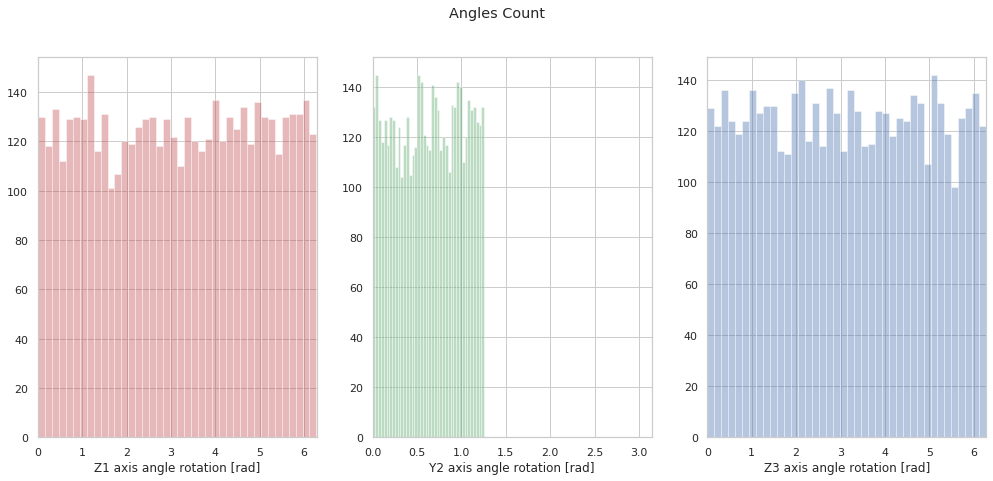

In [11]:
plot_angles_count(angles_true)

In [12]:
from cryoem.distance_estimation import global_standardization

In [13]:
X, y = np.array(projections, dtype=np.float32), np.array(angles_true, dtype=np.float32)

In [14]:
X = global_standardization(X)

Image shape: (116, 116)
Data Type: float32
***
Mean: 0.262 | Std: 1.046
Min:  0.000 | Max: 15.458
Mean: 0.000 | Std: 1.000
Min:  -0.250 | Max: 14.526


In [15]:
channels = "gray"
if channels == "rgb":
    X = np.stack((X,)*3, axis=-1)
elif channels == "gray":
    X = X[:,:,:,np.newaxis]

In [16]:
data = np.load(f"data/5j0n_siamese_idx.npz")
train_idx, val_idx, test_idx = data["arr_0"], data["arr_1"], data["arr_2"]

---

## Angle Recovery: Estimated Distance FULL

In [17]:
model_filename = "training/noisy_var0.h5"

# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model(model_filename)

# Show the model architecture
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 512)          4551936     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[1][0]                

In [18]:
from cryoem.conversions import d_q, euler2quaternion
from cryoem.plots import plot_dP_dQ

In [19]:
def d_p(p1, p2):
    p1 = tf.cast(p1, dtype=tf.float32)
    p2 = tf.cast(p2, dtype=tf.float32)
    return model.predict([p1, p2], batch_size=512)

In [20]:
batch_size = 512
idx1 = list(np.random.choice(range(5000), size=batch_size))
idx2 = list(np.random.choice(range(5000), size=batch_size))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

p1 = [X[i] for i in idx1]
p2 = [X[i] for i in idx2]

dP_values = d_p(p1, p2).T[0]
dQ_values = d_q(q1_true, q2_true).numpy()

<Figure size 432x288 with 0 Axes>

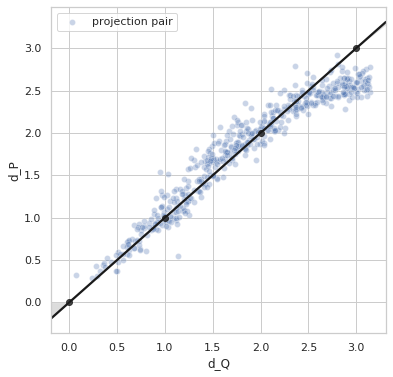

<Figure size 432x288 with 0 Axes>

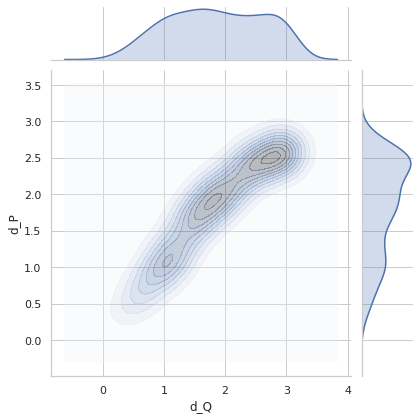

Variance = 0.22718810616761892
Min. angle recovery loss possible = 0.05151362613952923


In [21]:
plot_dP_dQ(dP_values, dQ_values);

#### Angle Recovery

In [21]:
from cryoem.angle_recovery import train_angle_recovery

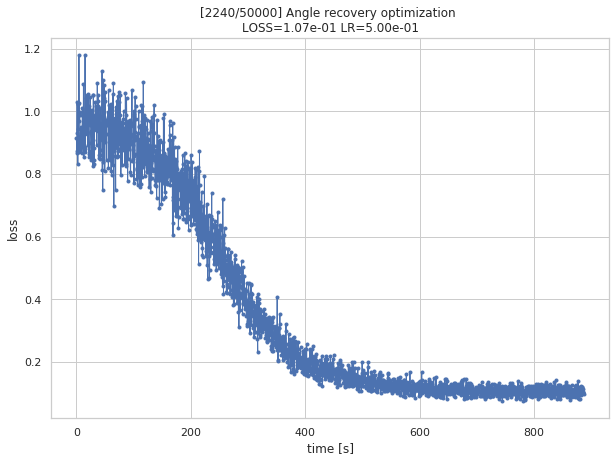

In [ ]:
q_predicted, losses, q_all = train_angle_recovery(steps=50000, 
                             batch_size=256, 
                             in_data=X[test_idx], 
                             distance_fn=d_p, 
                             learning_rate=0.5, 
                             limit_distance=np.pi,
                             file_name="data/5j0n/angle_recovery_limited3.14_estimated_50k_testset")

In [22]:
from cryoem.conversions import quaternion2euler

In [23]:
data = np.load("data/5j0n/angle_recovery_limited3.14_estimated_50k_testset.npz")
q_predicted, losses, q_all = data["arr_0"], data["arr_1"], data["arr_2"]

angles_predicted = quaternion2euler(q_predicted)

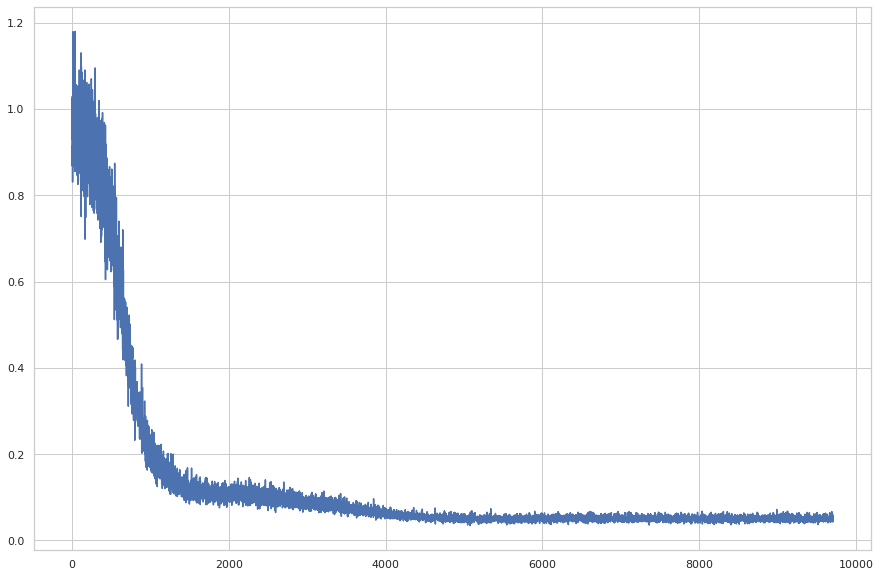

In [25]:
import seaborn as sns; sns.set(style="whitegrid", color_codes=True)
fig, ax = plt.subplots(figsize=(15,10))
plt.plot(losses[losses>1e-5])
plt.show()

In [26]:
np.mean(losses[losses>1e-6][-10:])

0.010507095707568255

In [27]:
#np.save("data/5j0n/projections_limited2.5_estimated_50k", projections)
#np.save("data/5j0n/angles_true_limited2.5_estimated_50k", angles_true)
np.save("data/5j0n/angles_predicted_limited3.14_estimated_50k_testset", angles_predicted)

### Angle Alignment

In [28]:
from cryoem.angle_alignment import training_angle_alignment, update_quaternion
from tensorflow.keras.optimizers import Adagrad, Ftrl

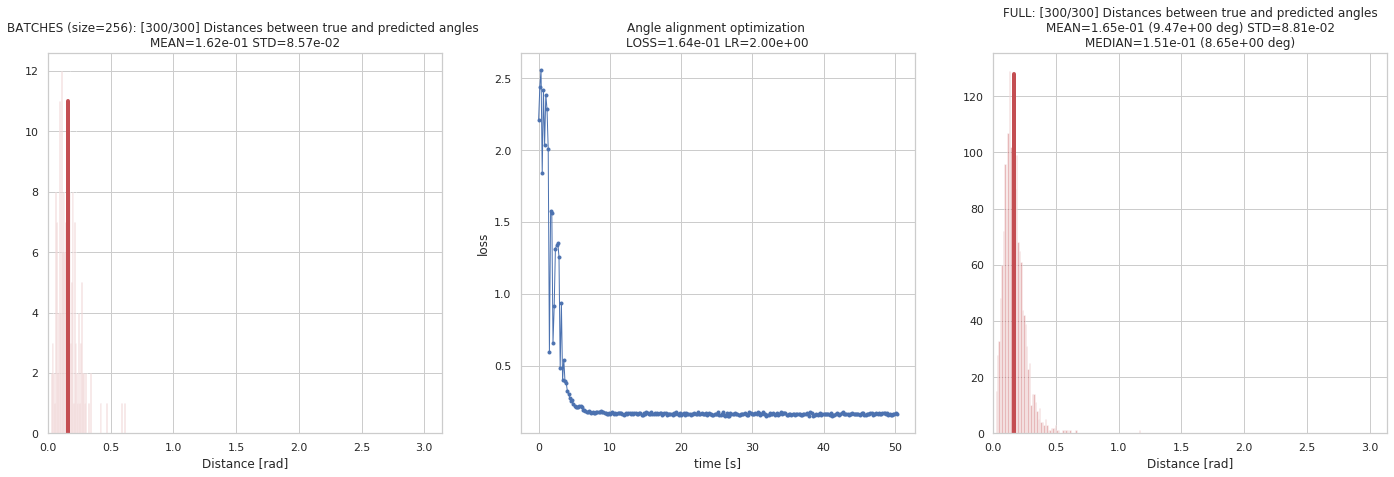

step 30/300 (5s): loss = 1.22e+00
step 60/300 (12s): loss = 1.87e-01
step 90/300 (17s): loss = 1.67e-01
step 120/300 (22s): loss = 1.67e-01
step 150/300 (26s): loss = 1.65e-01
step 180/300 (32s): loss = 1.64e-01
step 210/300 (36s): loss = 1.65e-01
step 240/300 (41s): loss = 1.63e-01
step 270/300 (46s): loss = 1.63e-01
step 300/300 (51s): loss = 1.67e-01



In [30]:
m, a_R, losses, collect_data, trajectory = training_angle_alignment(num_runs=3, 
                                                        steps=300, 
                                                        batch_size=256, 
                                                        optimizer=Ftrl(learning_rate=2., learning_rate_power=-2.), 
                                                        angles_true=angles_true[test_idx], 
                                                        angles_predicted=angles_predicted)

In [31]:
losses[-1], m, a_R

(0.16277109218343463,
 [1.0, 1.0, 1.0, -1.0],
 [<tf.Variable 'Variable:0' shape=(6,) dtype=float64, numpy=
  array([ 34.03594708, -18.88188682, -47.3558947 ,  41.5204078 ,
          26.97681418, -22.67913922])>])

In [32]:
q_predicted_rotated =  update_quaternion(m, a_R, q_predicted)

angles_predicted_rotated = quaternion2euler(q_predicted_rotated)

np.save("data/5j0n/angles_predicted_rotated_limited3.14_estimated_50k_testset", angles_predicted_rotated)

In [33]:
from cryoem.plots import plot_iterations_polar_plot, plot_iterations_rotvec

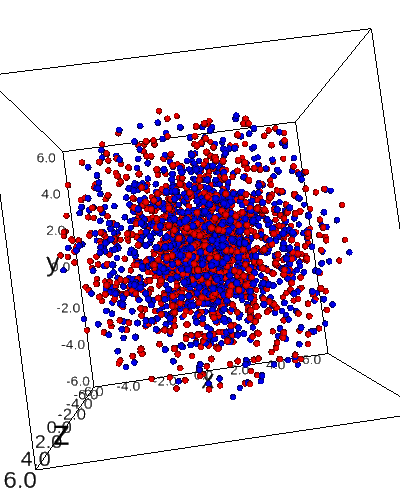

In [35]:
plot_iterations_polar_plot(collect_data, angles_true[test_idx], interval=200, connections=False, selected=None)

In [36]:
ipv.screenshot()

Output()

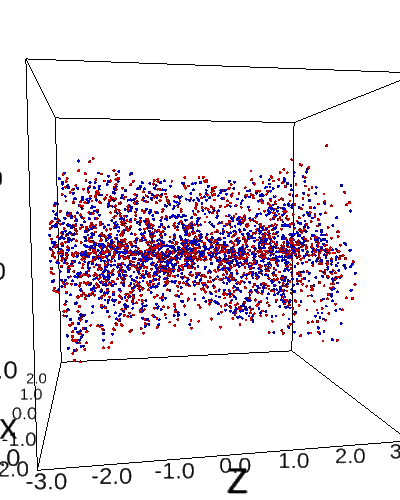

In [37]:
plot_iterations_rotvec(collect_data, angles_true[test_idx], interval=200)

In [38]:
ipv.screenshot()

Output()